In [23]:
import os
import platform
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack
import tensorflow as tf
# Suppress warnings
warnings.filterwarnings('ignore')

In [3]:
# Function to load the dataset based on the operating system
def load_dataset():
    os_type = platform.system()
    if os_type.startswith("Darwin"):
        dataset_path = "dataset/processed_data/main/final_cleaned_dataset.xlsx"
    else:
        dataset_path = "dataset\\processed_data\\main\\final_cleaned_dataset.xlsx"
    return pd.read_excel(dataset_path)

In [4]:
# Data preprocessing
def preprocess_data(data):
    # Drop target and irrelevant columns
    features = data.drop(columns=[
        "Laboratory confirmed, since the beginning of the pandemic Hospitalized",
        "District", "Unnamed: 0", "Laboratory confirmed, since the beginning of the pandemic TOTAL",
        "Laboratory confirmed, since the beginning of the pandemic RecoveredA",
        "Laboratory confirmed, since the beginning of the pandemic Deceased"
    ])
    
    # Initialize the 'flag' column based on specified conditions
    data['flag'] = 3
    data.loc[data['Laboratory confirmed, since the beginning of the pandemic Hospitalized'] <= 449, 'flag'] = 2
    data.loc[data['Laboratory confirmed, since the beginning of the pandemic Hospitalized'] <= 290, 'flag'] = 1

    # Define features and target column
    target_col = data["flag"]

    return features, target_col


In [12]:
from sklearn.metrics import mean_squared_error,r2_score

data = load_dataset()

features, target_col = preprocess_data(data)
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, target_col, test_size=0.3, random_state=22)

# Define a range of neighbor values to test
neighbor_range = range(1, 21)

# Initialize variables to track best parameters and performance
best_mse = float('inf')
ideal_neighbors = None

mse_values = []
neighbors_counts = []
iterations = 0

# Iterate over different neighbor values
for n_neighbors in neighbor_range:
    knn_regressor = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_regressor.fit(X_train, y_train)
    y_val_pred = knn_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    
    mse_values.append(mse)
    neighbors_counts.append(n_neighbors)
    
    if mse < best_mse:
        best_mse = mse
        ideal_neighbors = n_neighbors
        
    iterations += 1
print(f"Ideal number of neighbors: {ideal_neighbors}")
print(f"total iterations: {iterations}")

Ideal number of neighbors: 7
total iterations: 20


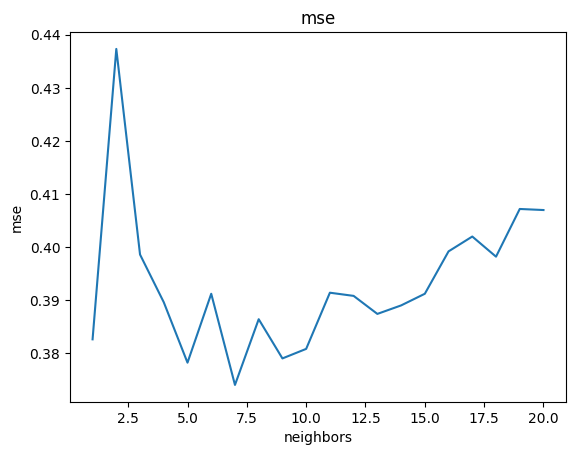

In [14]:
import matplotlib.pyplot as plt
plt.plot(neighbors_counts, mse_values)
plt.title('mse')
plt.xlabel('neighbors')
plt.ylabel('mse')
plt.show()

In [8]:
# Read the data from the Excel file
data = load_dataset()

features, target_col = preprocess_data(data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target_col, test_size=0.3, random_state=29)

# Create KNeighborsClassifier without the n_estimators argument
model = KNeighborsClassifier(n_neighbors=7)

# Fit the model
model.fit(X_train, y_train)

# Create ART classifier for scikit-learn KNeighborsClassifier
art_classifier = SklearnClassifier(model=model)

# Create ART Zeroth Order Optimization attack
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False,
                use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

# Generate adversarial samples with ART Zeroth Order Optimization attack
x_train_adv = zoo.generate(X_train.values)
x_test_adv = zoo.generate(X_test.values)


ZOO: 100%|██████████████████████████████████| 5010/5010 [01:09<00:00, 72.52it/s]


In [18]:
np.save('zoo_knn_train_adv.npy', x_train_adv )
np.save('zoo_knn_test_adv.npy', x_test_adv)

In [16]:
# Evaluate model scores
def evaluate_model(model, X, y):
    score = model.score(X, y)
    return score

In [27]:

def print_classification_report(test_data_x, test_data_y):
    # Predict the classes
    y_pred_classes = model.predict(test_data_x)
#     y_pred_classes = tf.argmax(y_pred, axis=1)
#     report = classification_report(test_data_y, y_pred_classes)

    # Calculate overall metrics
    accuracy = accuracy_score(test_data_y, y_pred_classes)
    precision = precision_score(test_data_y, y_pred_classes, average='weighted')  # You can use 'micro', 'macro', or 'weighted'
    recall = recall_score(test_data_y, y_pred_classes, average='weighted')  # You can use 'micro', 'macro', or 'weighted'
    f1 = f1_score(test_data_y, y_pred_classes, average='weighted')  # You can use 'micro', 'macro', or 'weighted'

    # Print or use the values as needed
    print("########### evaluation matrices ###########")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [17]:
# Evaluate the model on various datasets
scores = {
    "Normal Training Score": evaluate_model(model, X_train, y_train),
    "Adversarial Training Score": evaluate_model(model, x_train_adv, y_train),
    "Normal Test Score": evaluate_model(model, X_test, y_test),
    "Adversarial Test Score": evaluate_model(model, x_test_adv, y_test)
}

for score_name, score_value in scores.items():
    print(f"{score_name}: {score_value:.4f}")

# Predict using the model and calculate performance metrics
y_pred = model.predict(X_test)

# Calculate accuracy, recall, precision, and F1 score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

Normal Training Score: 0.7927
Adversarial Training Score: 0.3772
Normal Test Score: 0.7447
Adversarial Test Score: 0.7425
Accuracy: 0.74
Recall: 0.74
Precision: 0.74
F1 Score: 0.74


In [32]:
print_classification_report(X_train, y_train)
print_classification_report(X_test, y_test)

########### evaluation matrices ###########
Accuracy: 0.7927288280581694
Precision: 0.7884852025549481
Recall: 0.7927288280581694
F1 Score: 0.7898472204047438
########### evaluation matrices ###########
Accuracy: 0.7447105788423154
Precision: 0.7398819453244496
Recall: 0.7447105788423154
F1 Score: 0.7418072302333495


In [31]:
print_classification_report(x_train_adv, y_train)
print_classification_report(x_test_adv, y_test)

########### evaluation matrices ###########
Accuracy: 0.37715996578272026
Precision: 0.371357953865576
Recall: 0.37715996578272026
F1 Score: 0.3739156273162685
########### evaluation matrices ###########
Accuracy: 0.7425149700598802
Precision: 0.7375551954678637
Recall: 0.7425149700598802
F1 Score: 0.7395125261969248


In [35]:
import json

def print_average_perturbations(adv_data, original_data):
    # Compute the difference between the original and adversarial samples
    perturbations = adv_data - original_data
    # Calculate the average perturbation for each feature
    average_perturbations = np.mean(np.abs(perturbations), axis=0)

    result_dict = dict(zip(original_data.columns, average_perturbations))

    print(json.dumps(result_dict, indent=2))

In [38]:
print_average_perturbations(x_test_adv, X_test)

{
  "Laboratory confirmed, since the beginning of the pandemic Difference from": 0.00013346624618280908,
  "Laboratory confirmed, since the beginning of the pandemic Current CasesB": 0.0005455517990434216,
  "Reported, the last 7 days,Incidence per 100, Incidence per 100 ,+USAFD": 5.2498192981837275e-05,
  "Reported, the last 7 days,Incidence per 100, Incidence per 100 ,<20 Jahre": 0.00015906173221863612,
  "Reported, the last 7 days,Incidence per 100, Incidence per 100 ,20-59 JahreE": 0.00025313510420079717,
  "Reported, the last 7 days,Incidence per 100, Incidence per 100 ,>=60 Jahre": 0.00019223251367362398
}


In [39]:
x_test_adv_new = zoo.generate(X_test.values)

ZOO: 100%|██████████████████████████████████| 5010/5010 [01:09<00:00, 71.98it/s]


In [40]:
print_average_perturbations(x_test_adv_new, X_test)

{
  "Laboratory confirmed, since the beginning of the pandemic Difference from": 9.979749035216615e-05,
  "Laboratory confirmed, since the beginning of the pandemic Current CasesB": 0.0003187697358474046,
  "Reported, the last 7 days,Incidence per 100, Incidence per 100 ,+USAFD": 0.0001191202484916718,
  "Reported, the last 7 days,Incidence per 100, Incidence per 100 ,<20 Jahre": 0.00023293404016428126,
  "Reported, the last 7 days,Incidence per 100, Incidence per 100 ,20-59 JahreE": 0.00020702890228467785,
  "Reported, the last 7 days,Incidence per 100, Incidence per 100 ,>=60 Jahre": 0.00017946922047641834
}


In [41]:
print_average_perturbations(x_train_adv, X_train)

{
  "Laboratory confirmed, since the beginning of the pandemic Difference from": 118.47080572834629,
  "Laboratory confirmed, since the beginning of the pandemic Current CasesB": 2012.734366354956,
  "Reported, the last 7 days,Incidence per 100, Incidence per 100 ,+USAFD": 475.75100205012507,
  "Reported, the last 7 days,Incidence per 100, Incidence per 100 ,<20 Jahre": 465.518417062905,
  "Reported, the last 7 days,Incidence per 100, Incidence per 100 ,20-59 JahreE": 634.4057620778347,
  "Reported, the last 7 days,Incidence per 100, Incidence per 100 ,>=60 Jahre": 590.4108297344055
}
